# Generating useful features for further analysis on Amazon reviews

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better results on larger datasets (such as book reviews).

We begin by loading the dataset below:

In [2]:
from tqdm import tqdm

In [3]:
import nltk # imports the natural language toolkit
nltk.download('punkt')
import pandas as pd
import string
import gzip
import plotly

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

AIV = getDF('reviews_Amazon_Instant_Video_5.json.gz')
TVM = getDF('reviews_Movies_and_TV_5.json.gz')

[nltk_data] Downloading package punkt to /home/daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
print(len(AIV))
print(AIV.head(10))

37126
       reviewerID        asin                    reviewerName   helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM    [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T    [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"    [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"    [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey    [1, 1]   
5  A1POFVVXUZR3IQ  B000H00VBQ                         Z Hayes  [12, 12]   
6  A1PG2VV4W1WRPL  B000H0X79O  Jimmy C. Saunders "Papa Smurf"    [0, 0]   
7   ATASGS8HZHGIB  B000H0X79O                         JohnnyC    [0, 0]   
8  A3RXD7Z44T9DHW  B000H0X79O                          Kansas    [0, 0]   
9   AUX8EUBNTHIIU  B000H0X79O             Louis V. Borsellino    [0, 0]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...      2.0   
1  I highly recommend this series. It 

In [5]:
print(len(TVM))
print(TVM.head(10))

1697533
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   
5  A2L0G56BNOTX6S  0005019281                     barbara whapeles  [0, 0]   
6   A5NYUBEKXFLX5  0005019281                  B. Babb "kites0852"  [1, 1]   
7  A2DJ8B8GE4V2VD  0005019281                        Berl S. Meyer  [0, 0]   
8   AWF2S3UNW9UA0  0005019281                          beth holman  [0, 0]   
9  A3O4UUT83DG3OU  0005019281                    Bettylou Sperling  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...      4.0   
1  

We notice that TVM is extremely long, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make the following run more quickly:

In [6]:
# TVM was annoyingly long while writing this - shorten it for now.
TVM = TVM.head(100000)
TVM = TVM.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

AIV = AIV.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
TVM.head(10)

helpful                                         reviewText  overall  \
0  [0, 0]  This is a charming version of the classic Dick...      4.0   
1  [0, 0]  It was good but not as emotionally moving as t...      3.0   
2  [0, 0]  Don't get me wrong, Winkler is a wonderful cha...      3.0   
3  [0, 0]  Henry Winkler is very good in this twist on th...      5.0   
4  [0, 0]  This is one of the best Scrooge movies out.  H...      4.0   
5  [0, 0]  This has been a favorite movie of mine for a l...      5.0   
6  [1, 1]  This is the American adaptation of the Charles...      5.0   
7  [0, 0]  Glad that this american classic came out on dv...      5.0   
8  [0, 0]  A good Christmas carol dhenry winkler one duri...      5.0   
9  [0, 0]  How a bitter old man comes to know the true me...      5.0   

                                            summary  unixReviewTime  
0                         good version of a classic      1203984000  
1                            Good but not as moving      1388361600  
2             Winkler's Performance was ok at best!      1388361600  
3      It's an enjoyable twist on the classic story      1202860800  
4                                  Best Scrooge yet      1387670400  
5                                  Dickens updated.      1383696000  
6  A MUST-HAVE FOR ANY VIDEO CHRISTMAS COLLECTION!!      1230595200  
7                       An American Christmas Carol      1260835200  
8                       an american christmas carol      1386201600  
9                                        Fantastic!      1379721600

In [7]:
AIV.head()

helpful                                         reviewText  overall  \
0  [0, 0]  I had big expectations because I love English ...      2.0   
1  [0, 0]  I highly recommend this series. It is a must f...      5.0   
2  [0, 1]  This one is a real snoozer. Don't believe anyt...      1.0   
3  [0, 0]  Mysteries are interesting.  The tension betwee...      4.0   
4  [1, 1]  This show always is excellent, as far as briti...      5.0   

                          summary  unixReviewTime  
0      A little bit boring for me      1399075200  
1           Excellent Grown Up TV      1346630400  
2           Way too boring for me      1381881600  
3     Robson Green is mesmerizing      1383091200  
4  Robson green and great writing      1234310400

### Exercise 1:

Plot histograms of all numeric quantities and compute pairwise correlations between them. Do you notice anything interesting?

**Answer:**

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [9]:
helpfulR = TVM.helpful.apply(lambda x: x[0])
helpfulT = TVM.helpful.apply(lambda x: x[1])

In [10]:
TVM['helpfulR'] = helpfulR
TVM['helpfulT'] = helpfulT

(array([ 4726.,     0.,  4575.,     0.,     0.,  9166.,     0., 21022.,
            0., 60511.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

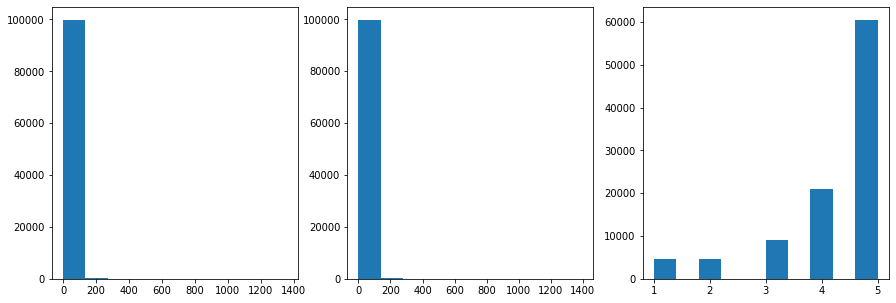

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(helpfulR)

plt.subplot(1,3,2)
plt.hist(helpfulT)

plt.subplot(1,3,3)
plt.hist(TVM.overall)

In [12]:
helpfulRAIV = AIV.helpful.apply(lambda x: x[0])
helpfulTAIV = AIV.helpful.apply(lambda x: x[1])

In [13]:
AIV['helpfulR'] = helpfulRAIV
AIV['helpfulT'] = helpfulTAIV

In [14]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(AIV.helpfulR)

plt.subplot(1,3,2)
plt.hist(AIV.helpfulT)

plt.subplot(1,3,3)
plt.hist(AIV.overall)

(array([ 1718.,     0.,  1885.,     0.,     0.,  4187.,     0.,  8446.,
            0., 20890.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

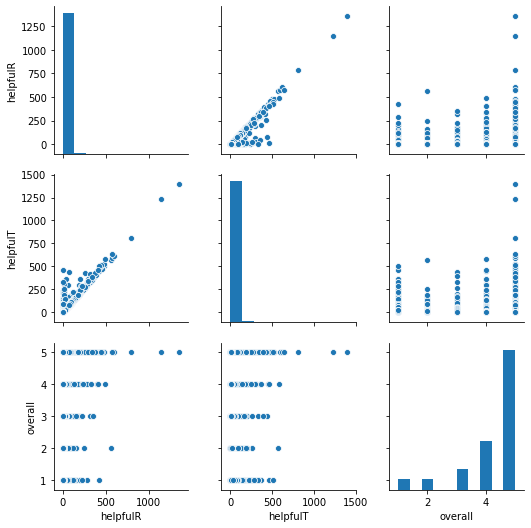

In [15]:
sns.pairplot(vars=['helpfulR','helpfulT','overall'],data=TVM)


In [16]:
sns.pairplot(vars=['helpfulR','helpfulT','overall'],data=AIV)

In TVM the total users on helpful , had a similar behavior that the really helped users, but in AIV there are a different behavior, the reviews  with higher overall are more helpful than the low reviews

### Exercise 2:

Find ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?

**Answer:**

In [17]:
from collections import Counter
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def top_k_words(text,k):
    list_reviews = text.apply(lambda x: re.sub(r"[^\w]"," ",x).split())
    list_of_tokens = [x for sublist in list_reviews for x in sublist]
    stopwords_list = list(stopwords.words("english"))
    list_clear =[]
    for i in list_of_tokens:
        if i.lower() not in stopwords_list:
            list_clear.append(i)
    n_counter = Counter(list_clear)
    most_common_k = n_counter.most_common(k)
    return(most_common_k)
    
    

In [19]:
print('-------------TVM REVIEWS----------------\n\n')
print('ALL REVIEWS {}'.format(top_k_words(TVM.reviewText,10)),"\n")
print('POSITIVE REVIEWS {}'.format(top_k_words( TVM.loc[TVM.overall>3,'reviewText'],10  )  ),"\n"  )
print('NEGATIVE REVIEWS {}'.format(top_k_words( TVM.loc[TVM.overall<3,'reviewText'],10  )  ),"\n"  )

-------------TVM REVIEWS----------------


ALL REVIEWS [('movie', 142835), ('film', 116172), ('one', 75661), ('like', 47278), ('quot', 44715), ('good', 41642), ('great', 40579), ('time', 38394), ('story', 34189), ('well', 30224)] 

POSITIVE REVIEWS [('movie', 112853), ('film', 92357), ('one', 61529), ('great', 35643), ('like', 35226), ('quot', 34366), ('good', 31809), ('time', 31577), ('story', 27614), ('well', 25123)] 

NEGATIVE REVIEWS [('movie', 15750), ('film', 10693), ('one', 6996), ('like', 6139), ('quot', 5348), ('would', 4045), ('good', 4043), ('even', 3476), ('time', 3271), ('really', 3153)] 



The results was as i expected because are movie reviews, there's no weird that appears the words: 'movie','film','like','good','great','time.

### Exercise 3:

Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?

**Answer:**

In [20]:
list_goods_negative = TVM.loc[TVM.overall<3,'reviewText'].apply(lambda x: x if re.search('good',x) else np.nan)
list_goods_negative.dropna(inplace=True)
list_goods_negative.reset_index(drop=True,inplace=True)
for i in list_goods_negative.head(10):
    print(i+'\n\n')

The acting was good, the story was correct, but naked backsides was not necessary.  Also the Potiphers wife did not need to be so very seductive of a naked Joseph. Not a Christian movie.  I felt that even though it was probably portrayed truthfully, Christans do not need to see so explicit a scene.  This should be rated PG 13 at least.


The DVD transfer is pretty good but the scene with Yukon discovering peppermint has been cut.It seems pretty odd to sell a DVD as a restored classic only to leave out the main thing that was to be restored!


ANOTHER American cultural icon from the 60's has beendeemed unacceptable by those who would prefer to seemalice where none exists.Not even Underdog can escape the slings and arrows ofthose with the same mentality as the book-burners of1930's Germany.Why do we allow such obvious Orwellian "Newsspeak" toedit our past? Come on... this IS a cartoon, for Pete'ssake, NOT some social/political statement.Nothing here needs to be edited or "cleaned up". Th

The next step could be to check what was good on the movie, since these reviews

### Exercise 4:

Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

**Answer:**

In [21]:
re.findall(pattern,list_goods_negative[0])[0]

'good, the story was correct, but naked backsides was not necessary.  Also the Potiphers wife did not need to be so very seductive of a naked Joseph. Not a Christian movie.  I felt that even though it was probably portrayed truthfully, Christans do not need to see so explicit a scene.  This should be rated PG 13 at least.'

In [22]:
re.split(r'\s',re.findall(pattern,list_goods_negative[0])[0])[1]

'the'

In [23]:
pattern = r"good.*"

list_first_post_negative = []

for x in list_goods_negative:
    y = re.split(r'\s',re.findall(pattern,x)[0])
    if len(y)>1 and y[1]!="":
        list_first_post_negative.append(y[1])
counter_fpn = Counter(list_first_post_negative)        
print('First word for good in negative reviews')
print('TVM')
counter_fpn.most_common(20)

First word for good in negative reviews
TVM


[('as', 113),
 ('and', 108),
 ('but', 95),
 ('movie', 67),
 ('thing', 64),
 ('job', 47),
 ('to', 40),
 ('in', 39),
 ('movie.', 34),
 ('about', 30),
 ('I', 28),
 ('idea', 28),
 ('for', 28),
 ('movie,', 24),
 ('acting', 22),
 ('actors', 22),
 ('the', 21),
 ('things', 21),
 ('at', 20),
 ('or', 19)]

In [24]:
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
#nltk.help.upenn_tagset('CD$')
#nltk.help.upenn_tagset('NN$')

[nltk_data] Downloading package tagsets to /home/daniel/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/daniel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [25]:
list_nn_cd = []
list_nn_cd_prev = []
patternPrev = r".*good"
pattern = r"good.*"
for i in range(len(list_goods_negative)):
    list_gn = nltk.word_tokenize(re.findall(pattern,list_goods_negative[i])[0])
    tag = nltk.pos_tag(list_gn)
    
    for j in range(len(tag)):
        if tag[j][1] == 'CD' or tag[j][1] == 'NN':
            list_nn_cd.append(tag[j][0])
            break        
        
        
    list_gn_prev = nltk.word_tokenize(re.findall(patternPrev,list_goods_negative[i])[0])
    tag_prev = nltk.pos_tag(list_gn_prev)
    
    for j in range(len(tag_prev)-1,0,-1):
        if tag_prev[j][1] == 'CD' or tag_prev[j][1] == 'NN':
            list_nn_cd_prev.append(tag_prev[j][0])
            break
    

In [26]:
print(len(list_nn_cd_prev))
print(len(list_nn_cd))

2709
2742


In [27]:
x42 = pd.DataFrame({'Before':list_nn_cd_prev[0:2700],'After':list_nn_cd[0:2700]})
print('Before\n');display(Counter(x42.Before).most_common(10))
print('\nAfter\n');display(Counter(x42.After).most_common(10))

Before



[('movie', 300),
 ('film', 134),
 ('one', 77),
 ('good', 56),
 ('acting', 52),
 ('quot', 42),
 ('story', 36),
 ('plot', 32),
 ('music', 20),
 ('way', 20)]


After



[('movie', 279),
 ('film', 99),
 ('thing', 81),
 ('one', 67),
 ('job', 66),
 ('acting', 47),
 ('idea', 44),
 ('story', 37),
 ('quot', 36),
 ('goodness', 35)]

### Exercise 5:

We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both, positive and negative reviews.

**Answer:**

In [28]:
from nltk.util import ngrams

In [29]:
def top_k_ngrams(text,n,k):
    
    list_reviews = text.apply(lambda x: re.sub(r"[^\w]"," ",x).split())
    list_of_tokens = [x for sublist in list_reviews for x in sublist]
    stopwords_list = list(stopwords.words("english"))
    
    list_clear =[]
    
    for i in list_of_tokens:
        if i.lower() not in stopwords_list:
            list_clear.append(i)
        
    n_gram_list = list(ngrams(list_clear,n))
    n_grams_strings = [' '.join(each) for each in n_gram_list]
    n_gram_counter = Counter(n_grams_strings)
    most_common_k = n_gram_counter.most_common(k)
    return(most_common_k)
    

In [30]:
print('\n       TVM Bigrams\n\n')
top_k_ngrams(TVM.reviewText,2,10)


       TVM Bigrams




[('special effects', 4727),
 ('one best', 4572),
 ('great movie', 3629),
 ('first time', 3159),
 ('Blu ray', 3120),
 ('good movie', 2985),
 ('years ago', 2543),
 ('ever seen', 2503),
 ('Blu Ray', 2427),
 ('ever made', 2414)]

In [31]:
print('\n       TVM Trigrams\n\n')
top_k_ngrams(TVM.reviewText,3,10)


       TVM Trigrams




[('Tommy Lee Jones', 969),
 ('Nightmare Elm Street', 674),
 ('movies ever made', 602),
 ('one favorite movies', 570),
 ('one best movies', 566),
 ('first time saw', 550),
 ('World War II', 494),
 ('New York City', 477),
 ('films ever made', 460),
 ('Robert De Niro', 455)]

In [32]:
print('\n       TVM Bigrams Negative\n\n')
top_k_ngrams(TVM.loc[TVM.overall<=2,'reviewText'],2,10)


       TVM Bigrams Negative




[('special effects', 534),
 ('waste time', 370),
 ('much better', 322),
 ('ever seen', 297),
 ('quot quot', 250),
 ('good movie', 246),
 ('looks like', 240),
 ('Blu ray', 232),
 ('blu ray', 230),
 ('look like', 228)]

In [33]:
print('\n       TVM Trigrams Negative \n\n')
top_k_ngrams(TVM.loc[TVM.overall<3,'reviewText'],3,10)


       TVM Trigrams Negative 




[('Tommy Lee Jones', 86),
 ('Nightmare Elm Street', 86),
 ('movies ever seen', 64),
 ('one worst movies', 63),
 ('worst movies ever', 59),
 ('movie ever made', 52),
 ('worst movie ever', 48),
 ('Texas Chainsaw Massacre', 48),
 ('movie ever seen', 46),
 ('waste time money', 46)]

In [34]:
print('\n       TVM Bigrams Positive \n\n')
top_k_ngrams(TVM.loc[TVM.overall>3,'reviewText'],2,10)


       TVM Bigrams Positive 




[('one best', 4281),
 ('special effects', 3673),
 ('great movie', 3323),
 ('first time', 2755),
 ('Blu ray', 2599),
 ('good movie', 2338),
 ('years ago', 2151),
 ('ever made', 2145),
 ('love movie', 2115),
 ('ever seen', 2095)]

In [35]:
print('\n       TVM Trigrams Positive \n\n')
top_k_ngrams(TVM.loc[TVM.overall>3,'reviewText'],3,10)


       TVM Trigrams Positive 




[('Tommy Lee Jones', 751),
 ('movies ever made', 547),
 ('one favorite movies', 541),
 ('one best movies', 539),
 ('first time saw', 500),
 ('Nightmare Elm Street', 495),
 ('World War II', 448),
 ('films ever made', 436),
 ('Robert De Niro', 400),
 ('one best films', 396)]

### Exercise 6:

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words.

**Answer**

We must check if there is an adjective and the closests next noun in the same sentence, with that we can have a global vision of the sense of that sentences.  

### Exercise 7:

Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return `["good movie", "long movie"]`.

In [39]:
list_nn_jj = []
for i in tqdm(range(len(TVM.reviewText) )):
    list_gn = nltk.word_tokenize(TVM.reviewText.array[i])
    tag = nltk.pos_tag(list_gn)  
    
    for j in range(len(tag)):
        if tag[j][1] == 'JJ':
            var1 = tag[j][0]
            for k in range(j,len(tag)):
                if tag[k][1] == 'NN':
                    var2 = tag[k][0]
                    list_nn_jj.append((var1,var2))
                    break
                                      

100%|██████████| 100000/100000 [19:57<00:00, 83.52it/s]


In [40]:
list_nn_jj = [' '.join(each) for each in list_nn_jj]
nn_jj = Counter(list_nn_jj)

In [41]:
nn_jj.most_common(20)

[('great movie', 4891),
 ('good movie', 4309),
 ('first time', 3126),
 ('great film', 2404),
 ('good film', 1805),
 ('first movie', 1609),
 ('same time', 1604),
 ('first film', 1517),
 ('many movie', 1446),
 ('high school', 1396),
 ('many film', 1383),
 ('real life', 1350),
 ('other movie', 1310),
 ('long time', 1299),
 ('great job', 1296),
 ('good job', 1261),
 ('great story', 1184),
 ('funny movie', 1165),
 ('other film', 1151),
 ('favorite movie', 1034)]